<a href="https://colab.research.google.com/github/nickchang001/Ad-Ranking-and-CTR-Prediction/blob/main/Ad_Ranking_and_CTR_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:
Developed an ads recommendation system based on 11 days of ads click/no click impression dataset on mobile device to increased CTR by providing personalized ads


Problems Solved:
1. Sparse feature:
 Feature embedding by GBDT+LR, FM.
 
 Consider userId as feature.(userid is important)
2. Feature interation: DeepFM in crease model generability
3. Label imbalance 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

import time
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve,  roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE


from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs
import warnings
warnings.filterwarnings("ignore")
import sklearn
import matplotlib.dates as mdates

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#chunksize = 10 ** 6
#num_of_chunk = 0
#train = pd.DataFrame()

#parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')   
#for chunk in pd.read_csv('/content/drive/MyDrive/Projects/CTR/train.csv', engine='python', delimiter=',' ,parse_dates = ['hour'], date_parser = parse_date, chunksize=chunksize):
#    num_of_chunk += 1
#    train = pd.concat([train, chunk.sample(frac=.05, replace=False, random_state=123)], axis=0)
#    print('Processing Chunk No. ' + str(num_of_chunk))     
    
#train.reset_index(inplace=True)

# 備份train 資料長度，以便稍後df重新分割索引用途
#train_len = len(train)
#train_len
#train.to_csv('/content/drive/MyDrive/Projects/sample_train.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Projects/sample_train.csv')
df.drop(labels=['index'], axis = 1, inplace=True)
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,2754752362988372739,1,2014-10-21 02:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,a8536f3a,711ee120,1,0,17753,320,50,1993,2,1063,-1,33
1,9630799129494811181,0,2014-10-21 02:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,210b723a,711ee120,1,0,15699,320,50,1722,0,35,100083,79
2,10482259799985475720,0,2014-10-21 02:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,225af2a8,b78e6543,1,0,15703,320,50,1722,0,35,100083,79
3,18308563816330684401,0,2014-10-21 04:00:00,1005,1,b8eae5f9,1e334bd3,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,469c435d,8a4875bd,1,0,19950,320,50,1800,3,167,100077,23
4,3559389347669503524,0,2014-10-21 02:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,d4e7897b,1f0bc64f,1,0,15701,320,50,1722,0,35,-1,79


In [ ]:
print(df.shape)

(2021448, 24)


#Part1: EDA

In [ ]:
#check missing value
df.isnull().any()

id                  False
click               False
hour                False
C1                  False
banner_pos          False
site_id             False
site_domain         False
site_category       False
app_id              False
app_domain          False
app_category        False
device_id           False
device_ip           False
device_model        False
device_type         False
device_conn_type    False
C14                 False
C15                 False
C16                 False
C17                 False
C18                 False
C19                 False
C20                 False
C21                 False
dtype: bool

Note: No missing value.

In [ ]:
#distribution of each categorical feature
df.describe()

,id,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06,2.021448e+06
mean,9.218109e+18,1.700731e-01,1.004969e+03,2.882340e-01,1.015307e+00,3.318859e-01,1.884284e+04,3.188822e+02,6.005369e+01,2.112584e+03,1.431725e+00,2.270127e+02,5.318717e+04,8.333984e+01
std,5.325791e+18,3.756971e-01,1.094232e+00,5.056662e-01,5.266572e-01,8.554913e-01,4.958722e+03,2.130750e+01,4.713234e+01,6.092307e+02,1.326632e+00,3.508460e+02,4.995869e+04,7.025499e+01
min,2.219877e+12,0.000000e+00,1.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.750000e+02,1.200000e+02,2.000000e+01,1.120000e+02,0.000000e+00,3.300000e+01,-1.000000e+00,1.000000e+00
25%,4.604298e+18,0.000000e+00,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.692000e+04,3.200000e+02,5.000000e+01,1.863000e+03,0.000000e+00,3.500000e+01,-1.000000e+00,2.300000e+01
50%,9.221590e+18,0.000000e+00,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,2.034600e+04,3.200000e+02,5.000000e+01,2.323000e+03,2.000000e+00,3.900000e+01,1.000480e+05,6.100000e+01
75%,1.382838e+19,0.000000e+00,1.005000e+03,1.000000e+00,1.000000e+00,0.000000e+00,2.189400e+04,3.200000e+02,5.000000e+01,2.526000e+03,3.000000e+00,1.710000e+02,1.000880e+05,1.010000e+02
max,1.844673e+19,1.000000e+00,1.012000e+03,7.000000e+00,5.000000e+00,5.000000e+00,2.405200e+04,1.024000e+03,1.024000e+03,2.758000e+03,3.000000e+00,1.839000e+03,1.002480e+05,2.550000e+02


Note: Click Through Rate is about 17%.

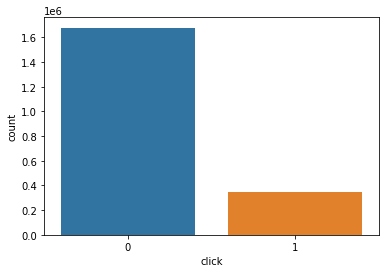

In [ ]:
sns.countplot(df['click'])
plt.show()

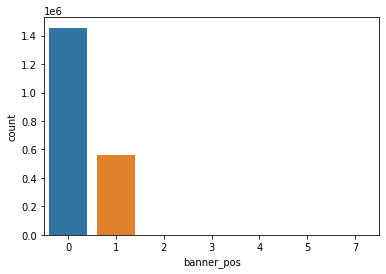

In [ ]:
#click distribution by banner positions
sns.countplot(df['banner_pos'])
plt.show()

Note: Ad positions 0 and 1 have most user clicked.

###Part: Correlation of each feature

AttributeError: ignored

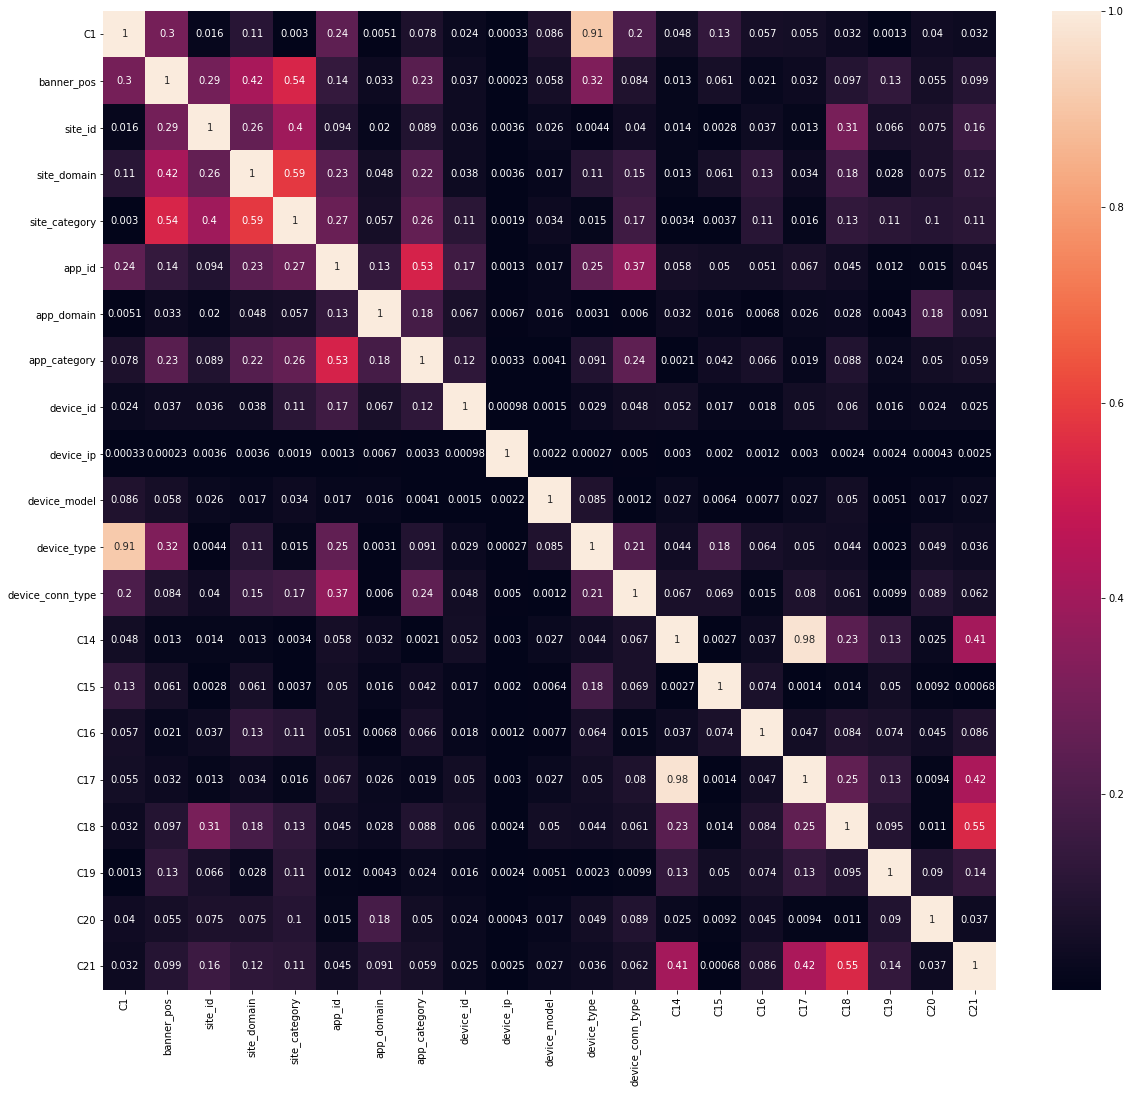

In [ ]:
#Label encode categorical feature which are object type
for column in ['C1', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model']:
    enc = preprocessing.LabelEncoder()
    df[column] = enc.fit_transform(df[column])

#Quick look the feature correlation, remove id, click.
sub_train = df.iloc[:, 3:]
plt.figure(figsize=(20, 18))
sns.heatmap(sub_train.corr().abs(), annot=True)
plt.show()

Note: C14 and C17 have strong correlation. Also, C1 and device_type have strong correlatoin.

In [ ]:
#Ceck which feature has highest correlation with click
corr_matrix = df.corr()
corr_matrix["click"].sort_values(ascending = False)

click               1.000000
C16                 0.128689
app_id              0.069924
banner_pos          0.027128
C18                 0.022445
device_id           0.008817
device_ip           0.001549
id                 -0.000796
device_model       -0.001694
site_category      -0.003064
C19                -0.003413
site_id            -0.006014
app_domain         -0.009369
C15                -0.032237
C1                 -0.035267
device_type        -0.038104
site_domain        -0.041123
app_category       -0.051826
C17                -0.055342
C20                -0.057165
C14                -0.059780
C21                -0.070652
device_conn_type   -0.084290
Name: click, dtype: float64

Note: C16 has highest correlation with click.

In [ ]:
#remove first 4 features
sub_train = df.iloc[:, 3:]
sub_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,2,1,2574,2109,21,3658,104,0,185771,637489,2564,1,0,17753,320,50,1993,2,1063,-1,33
1,2,0,372,3334,1,3658,104,0,185771,124684,2564,1,0,15699,320,50,1722,0,35,100083,79
2,2,0,372,3334,1,3658,104,0,185771,129527,4134,1,0,15703,320,50,1722,0,35,100083,79
3,2,1,2183,390,21,3658,104,0,185771,266814,3141,1,0,19950,320,50,1800,3,167,100077,23
4,2,0,372,3334,1,3658,104,0,185771,806168,673,1,0,15701,320,50,1722,0,35,-1,79


In [ ]:
for column in ['C1', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model']:
    enc = LabelEncoder()
    train[column] = enc.fit_transform(train[column])
    
sub_train = train.iloc[:, 4:]
plt.figure(figsize=(20, 18))
sns.heatmap(sub_train.corr().abs(), annot=True)
plot.show()

NameError: ignored

#Part2: Feature Engineering

**Ad id is very important feature. Recall increase 9% with including Ad id in our training data.**

###Patr2.0: Numerical variable Bucketing


*   Extracts the hour/day/month from the ''hour'' column.
*    We will only keep the hour because the data only have 11 consecutive days, month and day might not be reliable. 


In [ ]:
#Extrac hour of day from hour(including month, day, hour) column
df['hour_of_day'] = df['hour'].map(lambda x: int(str(x)[11:13]))

#drop hour
clean_df = df.drop(['hour'], axis=1)

#count # of data each hour
clean_df['hour_of_day'].value_counts()

13    119530
9     113719
12    110840
14    110040
10    107373
8     104839
15    103983
11    102749
16    102429
17    101811
5      99192
4      95500
7      92985
6      88095
18     87863
3      70009
19     65984
2      61236
20     56030
21     49443
1      49287
22     45259
0      42121
23     41131
Name: hour_of_day, dtype: int64

**Note: The distribution of hour are quite balance, we will not bucketize the hour first.

###Part2.1: Target Encoding

**Fore target encoding, we must split train test data before encoding in order to avoid infomation leak.**

In [ ]:
#install sklearn category encoder for target encoding  
!pip install category-encoders

In [ ]:
#Drop hour because our sample data only just includ single day 
clean_df = df.drop(columns=['hour'])
clean_df.columns

Index(['id', 'click', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [ ]:
#encoding include ad_id becasue ad_id is very import feature
from category_encoders import TargetEncoder
cat_feature = ['id','C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21']

encoder = TargetEncoder(cols = cat_feature)

#Train test Split 80% training, 20% test data
x_train, x_test, y_train, y_test = train_test_split(clean_df, clean_df['click'], test_size=0.2, random_state=99)

x_train_te = encoder.fit_transform(x_train[cat_feature], y_train)
x_test_te = encoder.transform(x_test[cat_feature], y_test)

x_train_te.head()

,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
1576628,0.170079,0.169576,0.184575,0.118474,0.122474,0.128339,0.117633,0.137814,0.108004,0.411271,0.107143,0.138155,0.169436,0.181517,0.097561,0.358079,0.158723,0.163502,0.146430,0.244237,0.19311,0.213761
852922,0.170079,0.169576,0.164256,0.205593,0.205593,0.208395,0.199108,0.195356,0.199623,0.174397,0.170079,0.253545,0.169436,0.181517,0.200556,0.158985,0.158723,0.189787,0.158279,0.167393,0.19311,0.188010
937869,0.170079,0.169576,0.164256,0.205593,0.205593,0.208395,0.199108,0.195356,0.199623,0.174397,0.181818,0.242350,0.169436,0.181517,0.208524,0.158985,0.158723,0.189787,0.158279,0.167393,0.19311,0.188010
774147,0.170079,0.169576,0.184575,0.282137,0.276313,0.180002,0.199108,0.195356,0.199623,0.174397,0.249999,0.209614,0.169436,0.181517,0.368708,0.158985,0.158723,0.363208,0.296003,0.358371,0.19311,0.394130
166590,0.170079,0.169576,0.164256,0.017843,0.024465,0.180002,0.199108,0.195356,0.199623,0.174397,0.045741,0.291039,0.169436,0.181517,0.098807,0.158985,0.158723,0.109084,0.158279,0.109084,0.19311,0.101929


###Patr2.2 Up sampling using SMOTE 

Notes: We must split data into train and test before SMOTE inorder to keep testing data as close as reality. 

In [ ]:
#Upsampling target encoded train and test data by using SMOTE technique
smote = SMOTE(random_state=12)
x_train_sm, y_train_sm = smote.fit_sample(x_train_te, y_train)

unique, counts = np.unique(y_train_sm, return_counts=True)
print(np.asarray((unique, counts)).T)

[[      0 1342113]
 [      1 1342113]]


In [ ]:
unique, counts = np.unique(y_train_sm, return_counts=True)
print(np.asarray((unique, counts)).T)

[[      0 1342113]
 [      1 1342113]]


###Part2.3: Label Encoding for LightGMB+LR
LightGBM expects categorical features as interger type.

Convert categorical feature to interger by using label encoding.

In [ ]:
#Build a label encoding function
from sklearn import preprocessing
def label_encode(df, target_col_name):
  le = preprocessing.LabelEncoder()

  features = []
  categorical_features = []
  num_of_columns = df.shape[1]

  #Loop through each col and label encode if the col is object
  for i in range(0, num_of_columns):
    column_name = df.columns[i]
    column_type = df[column_name].dtypes
  
    if column_name != target_col_name:
      features.append(column_name)
    
    if column_type == 'object':
      le.fit(df[column_name])
      feature_classes = list(le.classes_)
      encoded_feature = le.transform(df[column_name])
      df[column_name] = pd.DataFrame(encoded_feature)
    
      if column_name != target_col_name:
        categorical_features.append(column_name)
  return df, features, categorical_features

#Label encode categorical features
le_df, featues, cate_features = label_encode(clean_df, 'click')
le_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021448 entries, 0 to 2021447
Data columns (total 23 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   id                uint64
 1   click             int64 
 2   C1                int64 
 3   banner_pos        int64 
 4   site_id           int64 
 5   site_domain       int64 
 6   site_category     int64 
 7   app_id            int64 
 8   app_domain        int64 
 9   app_category      int64 
 10  device_id         int64 
 11  device_ip         int64 
 12  device_model      int64 
 13  device_type       int64 
 14  device_conn_type  int64 
 15  C14               int64 
 16  C15               int64 
 17  C16               int64 
 18  C17               int64 
 19  C18               int64 
 20  C19               int64 
 21  C20               int64 
 22  C21               int64 
dtypes: int64(22), uint64(1)
memory usage: 354.7 MB


In [ ]:
#from sklearn.feature_extraction import FeatureHasher
#featureHasher = FeatureHasher(n_feaures=) 

#OHE
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                    columns = feature_set,
                                    sparse = True)

    return new_data_frame

#Hash Trick
def convert_obj_to_int(self):
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self

ohe_features= ['C1','banner_pos','site_id','site_domain','site_category','app_id','app_domain',
              'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type',
              'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
#Remove userid b/c its too sparse
ohe_train = x_train.drop(labels=['id'], axis=1)
ohe_test  = x_test.drop(labels=['id'], axis=1 )

#One hot encoded categorical feature
hash_train = one_hot_features(ohe_train, ohe_features)
hash_test = one_hot_features(ohe_test, ohe_features)

In [ ]:
hash_train.columns()

TypeError: ignored

#Part3: Model Training

###Part3.0: Train Test Split

Only split label encoding data since target encoding data already split.

In [ ]:
#For LightGBM+LR stacking model we use label encoded data
from sklearn.model_selection import train_test_split

#Split tain and test data 
le_x_train, le_x_test, le_y_train, le_y_test = train_test_split(le_df, clean_df['click'], test_size=0.2, random_state=99)

#drop target column in training data
le_x_train.drop('click', axis=1 , inplace=True)
le_x_test.drop('click', axis=1, inplace=True )

#separate training data between GBDT and LR to avoid overfitting  
lgb_x_train, lr_x_train, lgb_y_train, lr_y_train = train_test_split(le_x_train, le_y_train, test_size=0.5)

lgb_x_train.shape

(808579, 22)

###Part3.1: Logistic Regression

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve,  roc_auc_score

#Confusion Matirx report function
def cf_report(y_true, y_pred):
  cm = metrics.confusion_matrix(y_true, y_pred)
  cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])

  print(cmDF)
  auc = roc_auc_score(y_true, y_pred)
  print('AUC score:',auc)
  print('recall =', float(cm[1,1])/(cm[1,0]+cm[1,1]))
  print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0
  return 


In [ ]:
#Train a Logistic Regression
import time
start = time.time()
#Build Logistic Regression Model
lr = LogisticRegression()

#lr_param_grid = {'C':[0.05, 0.3, 0.5, 1],
#              'max_iter':[10, 100, 500],
#              'class_weight':['balanced'],
#              'solver':['sag']
#              }

#optimized hyper parameter
lr_param_grid = {'C':[0.05, 0.3, 1],
              'max_iter':[10],
              'class_weight':['balanced'],
              'solver':['sag']
              }

# tune hyperparameters with GridSearch cross-validation
lr_clf = GridSearchCV(lr, param_grid=lr_param_grid, cv=5, scoring='auc')
lr_clf.fit(x_train_te, y_train)

#save best model
optimised_lr = lr_clf.best_estimator_

#get prediction value from best model
y_pred_train = optimised_lr.predict(x_train_te)
y_pred_test = optimised_lr.predict(x_test_te)

end = time.time()
print('Logistic Regression Cost %3.2f s.' %(end-start))

#get the optimized parameters
print("Best parameters set:")
lr_best_parameters = optimised_lr.get_params()
for param_name in sorted(lr_param_grid.keys()):
    print("\t%s: %r" % (param_name, lr_best_parameters[param_name]))


#Confusion Matirx of training data
print('Confusion Matrix for train data:')
report1=cf_report(y_train, y_pred_train)
print(report1)

#Confusion matrix of Testing data
print('Confusion Matrix for test data:')
report2=cf_report(y_test, y_pred_test)
print(report2)

Logistic Regression Cost 76.58 s.
Best parameters set:
	C: 1
	class_weight: 'balanced'
	max_iter: 10
	solver: 'sag'
Confusion Matrix for train data:
        pred_0  pred_1
true_0  964137  377976
true_1   72265  202780
AUC score: 0.7278168112367206
recall = 0.7372611754440183
precision = 0.3491655703944514
None
Confusion Matrix for test data:
        pred_0  pred_1
true_0  232925  102616
true_1   26744   42005
AUC score: 0.6525840839920607
recall = 0.6109907053193501
precision = 0.2904488283167728
None


*Notes: LR is quite fast. It only took about 1 min to run 2M row of dataset. And the result is quite good with 65% AUC.

In [ ]:
#Train a Logistic Regression
import time
start = time.time()
#Build Logistic Regression Model
lr = LogisticRegression()

#lr_param_grid = {'C':[0.05, 0.3, 0.5, 1],
#              'max_iter':[10, 100, 500],
#              'class_weight':['balanced'],
#              'solver':['sag']
#              }

#optimized hyper parameter
lr_param_grid = {'C':[1],
              'max_iter':[10],
              'class_weight':['balanced'],
              'solver':['sag']
              }

# tune hyperparameters with GridSearch cross-validation
lr_clf = GridSearchCV(lr, param_grid=lr_param_grid, cv=5, scoring='neg_log_loss')
lr_clf.fit(x_train_sm, y_train)

#save best model
optimised_lr = lr_clf.best_estimator_

#get prediction value from best model
y_pred_train = optimised_lr.predict(x_train_sm)
y_pred_test = optimised_lr.predict(x_test_te)

end = time.time()
print('Logistic Regression Cost %3.2f s.' %(end-start))

#get the optimized parameters
print("Best parameters set:")
lr_best_parameters = optimised_lr.get_params()
for param_name in sorted(lr_param_grid.keys()):
    print("\t%s: %r" % (param_name, lr_best_parameters[param_name]))


#Confusion Matirx of training data
print('Confusion Matrix for train data:')
report1=cf_report(y_train, y_pred_train)
print(report1)

#Confusion matrix of Testing data
print('Confusion Matrix for test data:')
report2=cf_report(y_test, y_pred_test)
print(report2)

Logistic Regression Cost 141.23 s.
Best parameters set:
	C: 1
	class_weight: 'balanced'
	max_iter: 10
	solver: 'sag'
Confusion Matrix for train data:
        pred_0  pred_1
true_0  983735  358378
true_1  378524  963589
AUC score: 0.7254694649407315
recall = 0.7179641356577278
precision = 0.7289054870507358
None
Confusion Matrix for test data:
        pred_0  pred_1
true_0  238536   97005
true_1   28314   40435
AUC score: 0.6495268603627522
recall = 0.5881540095128657
precision = 0.2942011059371362
None


*Notes: The result after SMOTE upsampling is a bit worse. It may because the data after upsampling introduce some noise.

###Part3.4 Degree-2 Polynominal (Poly2)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import time
start = time.time()

#buid a 2nd degree feature transformer
poly2 = PolynomialFeatures(degree=2)

#transform label encoded data to 2nd degree poly
#!!Both X_train and X_test need to do the same transformation b/c model will only acept the same demesion of input data
x_train_poly = poly2.fit_transform(x_train_te)
x_test_poly = poly2.fit_transform(x_test_te)
poly_lr = LogisticRegression()

#poly parameters for grid search CV
#poly_param_grid = {'C':[0.05, 0.3, 0.5, 1],
#              'max_iter':[10, 100, 500],
#              'class_weight':['balanced'],
#              'solver':['sag']
#              }

#optmized poly parameters for grid search CV

#poly_param_grid = {
#              'C':[1],
#              'max_iter':[10],
#              'class_weight':['balanced'],
#              'solver':['sag']
#              }

# tune hyperparameters with GridSearch cross-validation
#poly_clf = GridSearchCV(poly_lr, param_grid=poly_param_grid, cv=5, scoring='neg_log_loss')
#poly_clf.fit(x_train_poly, y_train)

#save best model
#optimised_poly = poly_clf.best_estimator_

#get prediction value from best model
#y_pred_train_poly = optimised_poly.predict(x_train_poly)
#y_pred_test_poly = optimised_poly.predict(x_test_poly)

#end = time.time()
#print('Poly2 Logistic Regression Cost %3.2f s.' %(end-start))

#get the optimized parameters
#print("Best parameters set:")
#poly_best_parameters = optimised_poly.get_params()
#for param_name in sorted(poly_param_grid.keys()):
#    print("\t%s: %r" % (param_name, poly_best_parameters[param_name]))


#Confusion Matirx of training data
print('Confusion Matrix for train data:')
report1=cf_report(y_train, y_pred_train_poly)
print(report1)

#Confusion matrix of Testing data
print('Confusion Matrix for test data:')
report2=cf_report(y_test, y_pred_test_poly)
print(report2)

Confusion Matrix for train data:
        pred_0  pred_1
true_0  931246  410867
true_1   61657  213388
AUC score: 0.7348474892147392
recall = 0.7758294097329528
precision = 0.3418282592850678
None
Confusion Matrix for test data:
        pred_0  pred_1
true_0  222155  113386
true_1   23910   44839
AUC score: 0.6571465834847126
recall = 0.6522131230999724
precision = 0.28338758097645755
None


*Note: Poly2 spent 4 times longer run time to get the result. And has only imporve 0.5% higher AUC and 4% higher recall than Logistic Regression. However, overfitting issue when using Poly2 model is even worse even we use L2 regulorization.  AUC of training has 12% higher than testing. When we use L1 regularization, the overfitting issue get much worse. 

###Part3.2: LightGBM

In [ ]:
#Train LightGBM with Target encode data
#define number of tree and leaf
n_estimators = 32
num_leaves = 64

# build model
lgb_clf = lgbm.sklearn.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         learning_rate = 0.1,
                         num_leaves = num_leaves,
                         n_estimators=n_estimators,
                         feature_fraction=0.8,
                         bagging_fraction= 0.9,
                         bagging_freq= 8,
                         lambda_l1= 0,
                         lambda_l2= 0.8)

start = time.time()

#param_grid = {
#    'min_data_in_leaf': [5,10,15],
#    'max_depth': [15,20,30],
#    'learning_rate': [0.1, 0.05],
#    'min_data_per_group': [5],
#    'num_leaves': [64],   # <= 2**max_depth
#    'regression_l2': [0],
#    'scale_pos_weight': [1]
#    }

#Best parameters
param_grid = {
    'min_data_in_leaf': [15],
    'max_depth': [64],
    'learning_rate': [0.5],
    'min_data_per_group': [5],
    'num_leaves': [128],   
    'regression_l2': [0],
    'scale_pos_weight': [1],
    'lambda_l2': [0.6],
    'n_estimators': [64]
    }

# tune hyperparameters with cross-validation
clf = GridSearchCV(lgb_clf, param_grid=param_grid, cv=5, scoring='neg_log_loss')

clf.fit(x_train_te, y_train)
#get the optimized model
optimised_lgbm = clf.best_estimator_
y_pred_train = optimised_lgbm.predict(x_train_te)
y_pred_test = optimised_lgbm.predict(x_test_te)

end = time.time()
print('LoghtGBM Cost %3.2f s.' %(end-start))

print("Best score: %0.3f" % clf.best_score_)
print("Best parameters set:")
best_parameters = optimised_lgbm.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

#Confusion Matirx of training data
print('Confusion Matrix for train data:')
lgbm_report1=cf_report(y_train, y_pred_train)
print(lgbm_report1)

#Confusion matrix of Testing data
print('Confusion Matrix for test data:')
lgbm_report2=cf_report(y_test, y_pred_test)
print(lgbm_report2)

LoghtGBM Cost 1373.20 s.
Best score: -0.362
Best parameters set:
	lambda_l2: 0.6
	learning_rate: 0.01
	max_depth: 64
	min_data_in_leaf: 15
	min_data_per_group: 5
	n_estimators: 128
	num_leaves: 256
	regression_l2: 0
	scale_pos_weight: 1
Confusion Matrix for train data:
         pred_0  pred_1
true_0  1336670    5443
true_1   248691   26354
AUC score: 0.5458807514354866
recall = 0.09581704811939865
precision = 0.8288203289618518
None
Confusion Matrix for test data:
        pred_0  pred_1
true_0  333249    2292
true_1   65937    2812
AUC score: 0.5170358266243384
recall = 0.040902413126009105
precision = 0.5509404388714734
None


*Note: LightGBM has worse AUC than poly2. 

In [ ]:
#Use Label encoding data to fead LightGBM
n_estimators = 32
num_leaves = 64

# build model
lgb = lgbm.sklearn.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         learning_rate = 0.1,
                         num_leaves = num_leaves,
                         n_estimators=n_estimators,
                         feature_fraction=0.8,
                         bagging_fraction= 0.9,
                         bagging_freq= 8,
                         lambda_l1= 0,
                         lambda_l2= 0.8)

start = time.time()

#param_grid = {
#    'min_data_in_leaf': [5,10,15],
#    'max_depth': [15,20,30],
#    'learning_rate': [0.1, 0.05],
#    'min_data_per_group': [5],
#    'num_leaves': [64],   # <= 2**max_depth
#    'regression_l2': [0],
#    'scale_pos_weight': [1]
#    }

#Best parameters
param_grid = {
    'min_data_in_leaf': [15],
    'max_depth': [15],
    'learning_rate': [0.1],
    'min_data_per_group': [5],
    'num_leaves': [64],   
    'regression_l2': [0],
    'scale_pos_weight': [1],
    'lambda_l2': [0.6],
    'num_leaves' : [64],
    'n_estimators': [64],
    }

# tune hyperparameters with cross-validation
clf = GridSearchCV(lgb, param_grid=param_grid, cv=5, scoring='neg_log_loss')

clf.fit(le_x_train, le_y_train)
#get the optimized model
optimised_lgbm = clf.best_estimator_
y_pred_train = optimised_lgbm.predict(le_x_train)
y_pred_test = optimised_lgbm.predict(le_x_test)

end = time.time()
print('LoghtGBM Cost %3.2f s.' %(end-start))

print("Best score: %0.3f" % clf.best_score_)
print("Best parameters set:")
best_parameters = optimised_lgbm.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

#Confusion Matirx of training data
print('Confusion Matrix for train data:')
lgbm_report1=cf_report(le_y_train, y_pred_train)
print(lgbm_report1)

#Confusion matrix of Testing data
print('Confusion Matrix for test data:')
lgbm_report2=cf_report(le_y_test, y_pred_test)
print(lgbm_report2)

LoghtGBM Cost 165.96 s.
Best score: -0.403
Best parameters set:
	lambda_l2: 0.6
	learning_rate: 0.1
	max_depth: 15
	min_data_in_leaf: 15
	min_data_per_group: 5
	n_estimators: 64
	num_leaves: 64
	regression_l2: 0
	scale_pos_weight: 1
Confusion Matrix for train data:
         pred_0  pred_1
true_0  1333238    8875
true_1   259836   15209
AUC score: 0.5243418495324595
recall = 0.055296406042647565
precision = 0.6314980900182694
None
Confusion Matrix for test data:
        pred_0  pred_1
true_0  333427    2114
true_1   65057    3692
AUC score: 0.5237011630102675
recall = 0.05370259931053543
precision = 0.6358939028591113
None


**Note:
Logist Regression has better perofrmance than LightGBM with 6% higher AUC. In addition, we use both target encode and label encoded data to train LightGBM model. The target encoded data has 4% higher auc than using lebel encoding data.

###Part3.3: Build and Tune LightGBM + LR with GridSearch Cross-Validation

In [ ]:
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,  roc_auc_score
from datetime import datetime
from sklearn.model_selection import GridSearchCV

#define number of tree and leaf
n_estimators = 32
num_leaves = 64

# build model
lgb = lgbm.sklearn.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         learning_rate = 0.1,
                         num_leaves = num_leaves,
                         n_estimators=n_estimators,
                         feature_fraction=0.8,
                         bagging_fraction= 0.9,
                         bagging_freq= 8,
                         lambda_l1= 0.6,
                         lambda_l2= 0)

start_time = datetime.now()

#param_grid = {
#    'min_data_in_leaf': [15,30],
#    'max_depth': [5, 10,15],
#    'learning_rate': [0.1, 0.05],
#    'min_data_per_group': [5, 10],
#    'num_leaves': [64],   # <= 2**max_depth
#    'regression_l2': [0],
#    'scale_pos_weight': [1, 1.2, 1.5]
#    }

#Best parameters
param_grid = {
    'min_data_in_leaf': [30],
    'max_depth': [10],
    'learning_rate': [0.1],
    'min_data_per_group': [5],
    'num_leaves': [64],   
    'regression_l2': [0],
    'scale_pos_weight': [1]
    }

# tune hyperparameters with cross-validation
clf = GridSearchCV(lgb, param_grid=param_grid, cv=5, scoring='neg_log_loss')

clf.fit(lgb_x_train, lgb_y_train)
#get the optimized model
optimised_lgbm = clf.best_estimator_

print('time for CV: ',datetime.now()-start_time)

print("Best score: %0.3f" % clf.best_score_)
print("Best parameters set:")
best_parameters = clf.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

time for CV:  0:00:41.174026
Best score: -0.407
Best parameters set:
	learning_rate: 0.1
	max_depth: 10
	min_data_in_leaf: 30
	min_data_per_group: 5
	num_leaves: 64
	regression_l2: 0
	scale_pos_weight: 1


In [ ]:
#Get leaves index of each training sample
gbdt_feats_train = optimised_lgbm.predict(lgb_x_train, pred_leaf = True)

#Predict test data and get the index of leaf
gbdt_feats_test = optimised_lgbm.predict(le_x_test, pred_leaf = True)


print('Shape of the leaves index output:', gbdt_feats_train.shape)

#print the first 5 samples
print('Have a peak of first 5 rows:\n' ,gbdt_feats_train[:5])

Shape of the leaves index output: (808579, 32)
Have a peak of first 5 rows:
 [[48  0 32 31 60 33  5 32 31 58 19 27 61 26 51 30 54 46 21  2 59 13 63 21
  27 25 39 10 29 16 36 13]
 [48  0 32 31 60 33  5 32 50 58 63 27 61 26 51 30 54 46 21  2 59 14 63 21
  27 35 43 10 29 16 33 13]
 [ 7 44 23 54  8 51 28 52 34 56 27 11 46 30 29  3  3  3 55 12  3 36 39 52
   5 52 33 35 53 49 35 38]
 [31 48 44 25 39  8 35 25  6 34 35  9 27  6 20 45 56 24  0 60 23 14 45 62
  13 28 29 10 29 20 46 23]
 [14  5  4 62 11  8 46  5 18 50 56  5 38 22 30  1 39 48 22  2 41 58 61 46
  47 62 11 14 51 55 35 62]]


In [ ]:
#Define a function to convert leaf index to dummy data
def leaf_idx_to_dummy(data, n_estimators):
  #build a dataframe
  gbdt_feats_name = ['gbdt_leaf_' + str(i) for i in range(n_estimators)]
  data = pd.DataFrame(data, columns = gbdt_feats_name)

  #One-Hot Encoding for leaf index
  for col in gbdt_feats_name:
    onehot_feats = pd.get_dummies(data[col], prefix = col)
    data.drop([col], axis = 1, inplace = True)
    data = pd.concat([data, onehot_feats], axis = 1)
  return data

dummy_lr_x_train = leaf_idx_to_dummy(gbdt_feats_train, n_estimators)
#Save the GBDT index data  because RAM will crash
#dummy_lr_x_train.to_csv('/content/drive/MyDrive/Projects/dummy_lr_x_train.csv', index=False)

dummy_lr_x_test = leaf_idx_to_dummy(gbdt_feats_test, n_estimators)
#dummy_lr_x_test.to_csv('/content/drive/MyDrive/Projects/dummy_lr_x_test.csv', index=False)

In [ ]:
#Train a Logistic Regression
import time

start = time.time()
#Build Logistic Regression Model
lr = LogisticRegression()

#lr_param_grid = {'C':[0.05, 0.3, 0.5, 1],
#              'max_iter':[10, 100, 500],
#              'class_weight':['balanced'],
#              'solver':['sag']
#              }

#optimized hyper parameter
lr_param_grid = {'C':[ 1],
              'max_iter':[100],
              'class_weight':['balanced'],
              'solver':['sag']
              }

# tune hyperparameters with GridSearch cross-validation
lr_clf = GridSearchCV(lr, param_grid=lr_param_grid, cv=5, scoring='neg_log_loss')

lr_clf.fit(dummy_lr_x_train, lr_y_train)
end = time.time()
print('Logistic Regression Cost %3.2f s.' %(end-start))
#get the optimized model
optimised_lr = lr_clf.best_estimator_
optimised_lr

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Confusion Matirx of training data
def cf_report(y_true, y_pred):
  cm = metrics.confusion_matrix(y_true, y_pred)
  cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])

  print(cmDF)
  auc = roc_auc_score(y_true, y_pred)
  print('AUC score of logist regreesion:',auc)
  print('recall =', float(cm[1,1])/(cm[1,0]+cm[1,1]))
  print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

#Print out test data result
lr_y_pred = optimised_lr.predict(dummy_lr_x_test)
cf_report(y_test, lr_y_pred)

*Notes: BGDT+LR even worse than just use LightGBM.

###Part3.4: DeepFM

In [ ]:
!pip install -U deepctr-torch

In [ ]:
#Drop hour column
df_no_hr = df.drop(['hour'], axis=1)
df_no_hr.head()

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,2754752362988372739,1,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,a8536f3a,711ee120,1,0,17753,320,50,1993,2,1063,-1,33
1,9630799129494811181,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,210b723a,711ee120,1,0,15699,320,50,1722,0,35,100083,79
2,10482259799985475720,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,225af2a8,b78e6543,1,0,15703,320,50,1722,0,35,100083,79
3,18308563816330684401,0,1005,1,b8eae5f9,1e334bd3,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,469c435d,8a4875bd,1,0,19950,320,50,1800,3,167,100077,23
4,3559389347669503524,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,d4e7897b,1f0bc64f,1,0,15701,320,50,1722,0,35,-1,79


In [ ]:
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr_torch.models import *
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
import torch
import time
time = time.time()

# 1.Prepare input data
#Sparse feature name 
sparse_features = ['id', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type'] + ['C' + str(i) for i in range(14, 22)]
#set label column
target = ['click']

#label encode categorical features
for feat in sparse_features:
    lbe = LabelEncoder()
    df_no_hr[feat] = lbe.fit_transform(df_no_hr[feat])

# 3.count #unique features for each sparse field,and record dense feature field name
#by default embedding_dim=4 , k=4
fixlen_feature_columns = [SparseFeat(feat, df_no_hr[feat].nunique()) for feat in sparse_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# 4.generate input data for model.  (idctionary format)
train, test = train_test_split(df_no_hr, test_size=0.2, random_state=2020)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

# 5.Define Model,train,predict and evaluate
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print('cuda ready...')
  device = 'cuda:0'
  #learning rate bt default=0.01
  model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
                   task='binary',
                   l2_reg_embedding=1e-5, device=device)

  model.compile("adagrad", "binary_crossentropy",
                metrics=["binary_crossentropy", "auc"], )

  history = model.fit(train_model_input, train[target].values, batch_size=64, epochs=3, verbose=2,
                        validation_split=0.2)
  pred_ans = model.predict(test_model_input, 64)
  end = time.time()
  print('DeepFM Cost %3.2f s.' %(end-start))
  print("")
  print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
  print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))


NameError: ignored

DeepFM with hour


In [ ]:
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr_torch.models import *
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
import torch
import time
start = time.time()

# 1.Prepare input data
#Sparse feature name 
sparse_features = ['id', 'C1', 'hour_of_day', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type'] + ['C' + str(i) for i in range(14, 22)]
#set label column
target = ['click']

#label encode categorical features
for feat in sparse_features:
    lbe = LabelEncoder()
    clean_df[feat] = lbe.fit_transform(clean_df[feat])

# 3.count #unique features for each sparse field,and record dense feature field name
#by default embedding_dim=4 , k=4
fixlen_feature_columns = [SparseFeat(feat, clean_df[feat].nunique()) for feat in sparse_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# 4.generate input data for model.  (idctionary format)
train, test = train_test_split(clean_df, test_size=0.2, random_state=2020)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

# 5.Define Model,train,predict and evaluate
device = 'gpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print('cuda ready...')
  device = 'cuda:0'
  #learning rate bt default=0.01, dnn_hidden_units=(256, 128), dnn_dropout=0, dnn_activation
  model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
                  dnn_hidden_units=(256,128),
                  dnn_use_bn= True, dnn_dropout=0.2, task='binary',
                  l2_reg_embedding=1e-5, device=device)

  model.compile("adagrad", "binary_crossentropy",
                metrics=["binary_crossentropy", "auc"], )

  history = model.fit(train_model_input, train[target].values, batch_size=1000, epochs=2, verbose=2,
                        validation_split=0.2)
  pred_ans = model.predict(test_model_input, 64)
  
  end = time.time()
  print('DeepFM Cost %3.2f s.' %(end-start))
  print("")
  print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
  print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))


cuda ready...
cuda:0
Train on 1293726 samples, validate on 323432 samples, 1294 steps per epoch
Epoch 1/2
52s - loss:  0.3999 - binary_crossentropy:  0.3999 - auc:  0.7431 - val_binary_crossentropy:  0.3953 - val_auc:  0.7537


KeyboardInterrupt: ignored

**Notes** 

*  By using the DeepFM model, we have the best AUC scroe. For batch size=64, the auc reaches 75.37% and  different between training auc is less than 0.5%.

*  After hour feature added into traing data, AUC incresing 0.1%.


*   Batch Size cannot be too small. If the batch size is too small, some batch are without true label which arrise error (moel cannnot learn).

#Part4: Result and Business Recommandation

###Part4.1: Feature importance from Logistic Regression , Poly2 and LightGBM 

In [ ]:
import lightgbm as lgb
#record training result
evals_result = {}

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 15,
    'num_round': 50,
    'max_depth':15,
    'learning_rate': 0.1,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.8,
    'bagging_freq': 12,
    'n_estimators': 64,
}
#feed data into model
lgb_train = lgb.Dataset(x_train_te, y_train)
lgb_test = lgb.Dataset(x_test_te, y_test, reference=lgb_train)

#train model
optimised_lgbm = lgb.train(lgb_params, lgb_train, evals_result=evals_result)


###Part4.1: Feature Importance Visualization

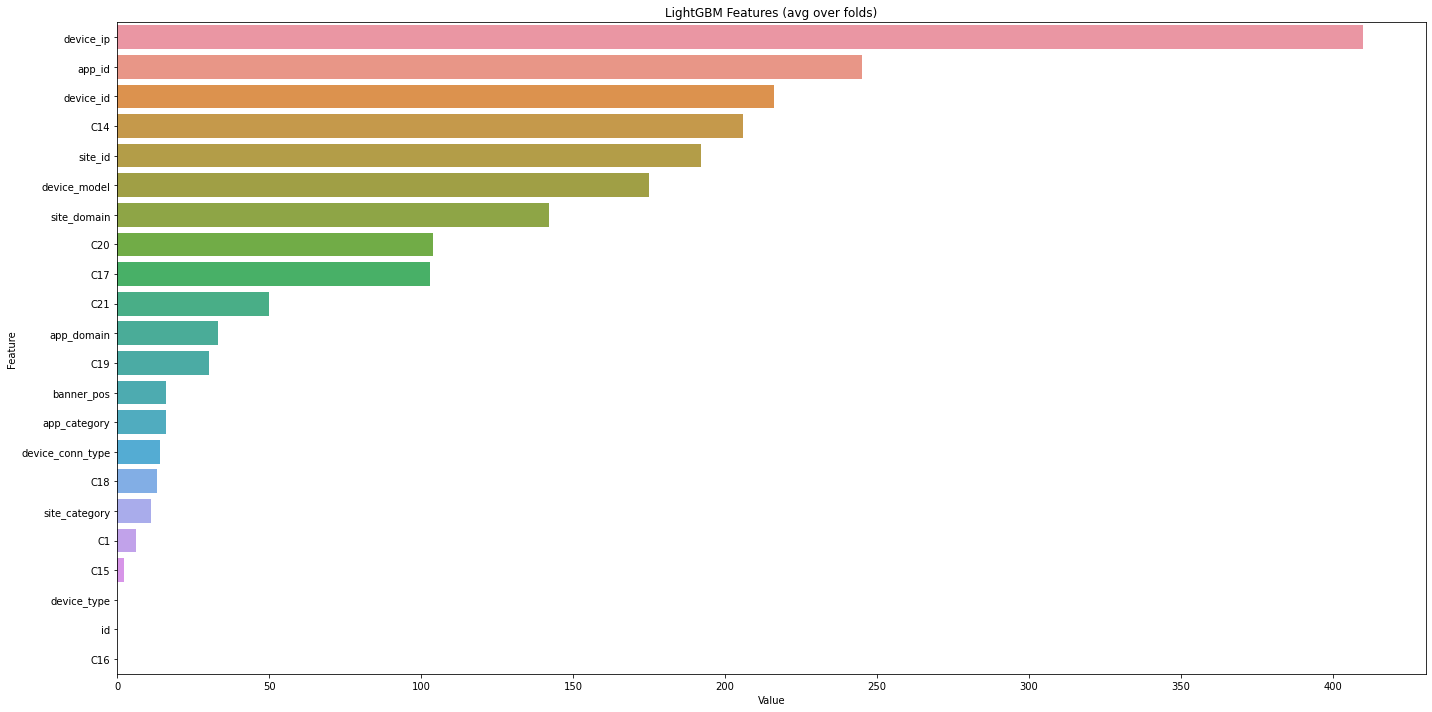

<Figure size 432x288 with 0 Axes>

In [ ]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(optimised_lgbm.feature_importances_, x_train_te.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

*Note: The top 5 important feature are device_ip, app_id, device_id, C14, site_id. However device_ip is much more importan than other features.

###Part4.2: LightGBM tree Visualization

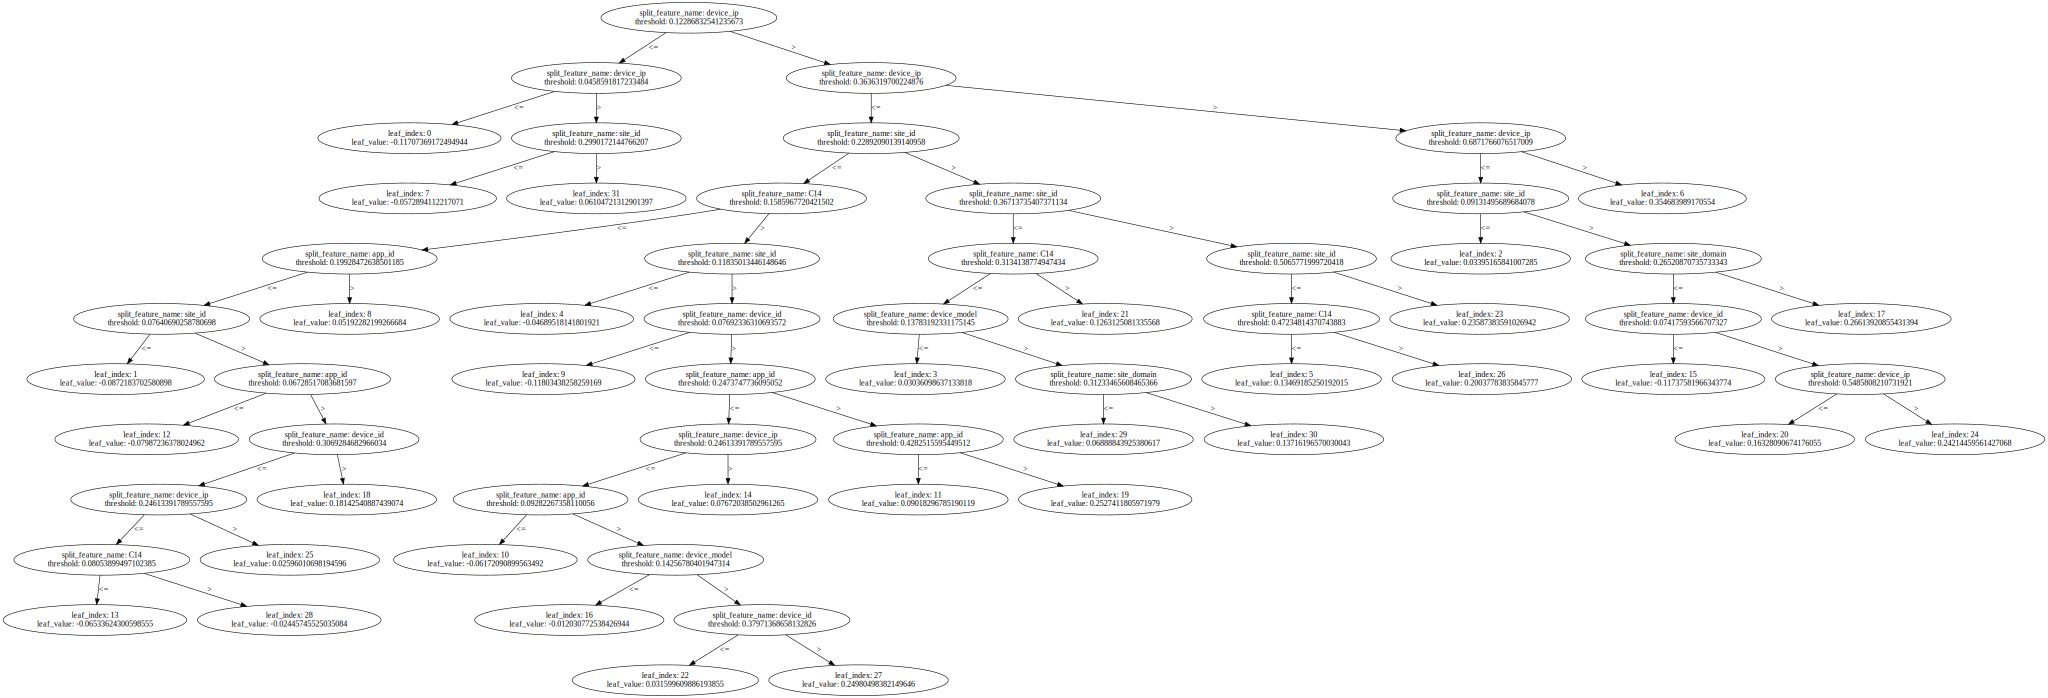

In [ ]:
lgb.create_tree_digraph(optimised_lgbm, tree_index=1)